# Autoregression with online learning

In [1]:
#!pip install ANNarchy

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import ANNarchy as ann

ANNarchy 4.8 (4.8.1) on darwin (posix).


In [3]:
ESN_Neuron = ann.Neuron(
    parameters = """
        tau = 30.0     : population   # Time constant
        g = 1.0        : population   # Scaling
        bias = 0.0                    # Bias
    """,
    equations="""
        tau * dx/dt + x = sum(in) + g * sum(exc) + bias
        r = tanh(x)
    """
)

In [4]:
class ESN_DeltaLearning:
    """
    Echo-state network with feedback and the delta learning rule.
    """
    def __init__(self, N:int, g:float, eta:float):
        """
        Args:
            N : number of neurons in the reservoir.
            g: spectral radius of the reservoir.
            eta: learning rate.
        """
        self.N = N
        self.g = g
        self.eta = eta

        # Clear ANNarchy, otherwise compile() cannot be called multiple times
        ann.clear()

        # Input population
        self.inp = ann.Population(1, ann.Neuron(parameters="r=0.0"))

        # Recurrent population
        self.pop = ann.Population(N, ESN_Neuron)
        self.pop.g = g
        self.pop.bias = np.random.uniform(-1., 1., self.N)

        # Feedback weights
        self.Wi = ann.Projection(self.inp, self.pop, 'in')
        self.Wi.connect_all_to_all(weights=ann.Normal(0.0, 1.0))

        # Recurrent weights
        self.Wrec = ann.Projection(self.pop, self.pop, 'exc')
        self.Wrec.connect_all_to_all(weights=ann.Normal(0., 1/np.sqrt(N)))

        # Output weights
        self.Wout = np.zeros((1, self.N))
        self.z = np.zeros(1)

        # Monitor
        self.monitor = ann.Monitor(self.pop, 'r')

        ann.compile()

    def step(self):
        "Performs one step of the simulation."

        # Set the previous readout output as the new input
        self.inp.r = self.z

        # Update the reservoir
        ann.step()

        # Compute the readout
        self.z = self.Wout @ self.pop.r

    def train(self, target:float):
        """
        Trains the readout weights with the delta learning rule.

        Args:
            target: desired output.
        """
        self.Wout += self.eta * np.outer(target - self.z, self.pop.r)


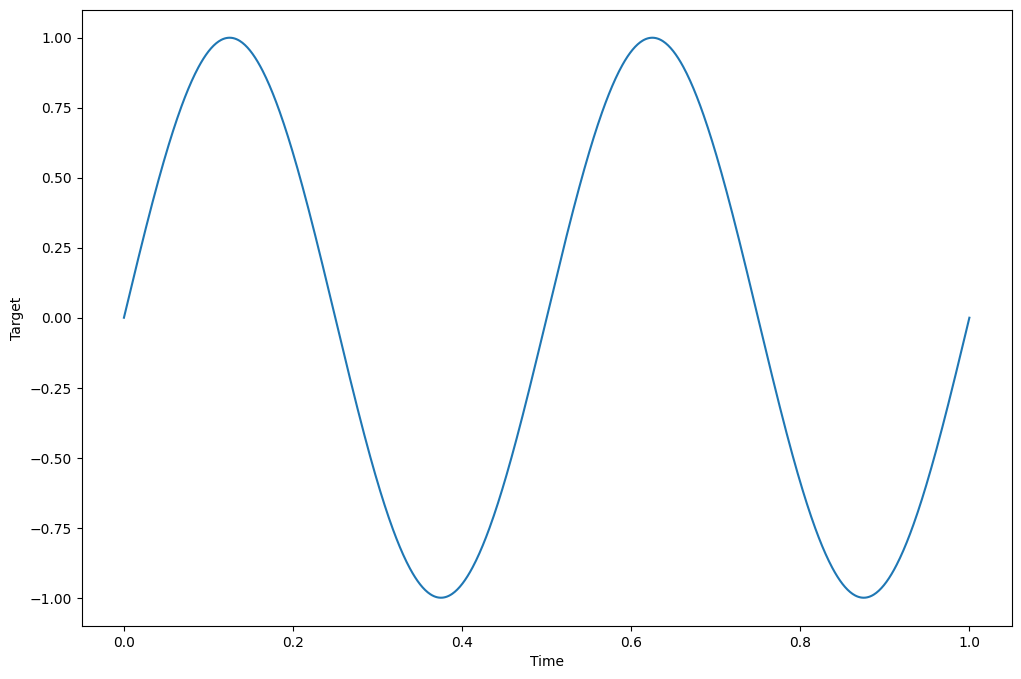

In [5]:
duration = 1000 # 1000 steps = one second
t = np.linspace(0, 1, duration) # time axis
X = np.sin(2*np.pi*t*2.)

plt.figure(figsize=(12, 8))
plt.plot(t, X)
plt.xlabel("Time")
plt.ylabel("Target")
plt.show()

In [6]:
net = ESN_DeltaLearning(N=200, g=1.0, eta=0.01)

readouts= []
for x in X:
    net.step()
    net.train(x)
    readouts.append(net.z[0])

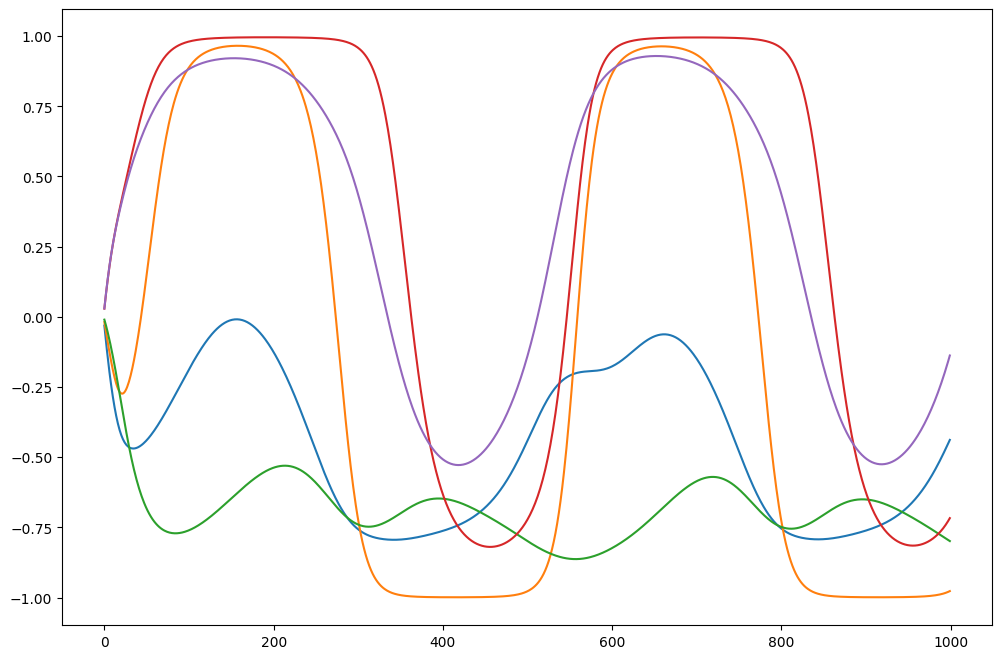

In [7]:
data = net.monitor.get('r')

plt.figure(figsize=(12, 8))
for n in range(5):
    plt.plot(data[:, n])
plt.show()

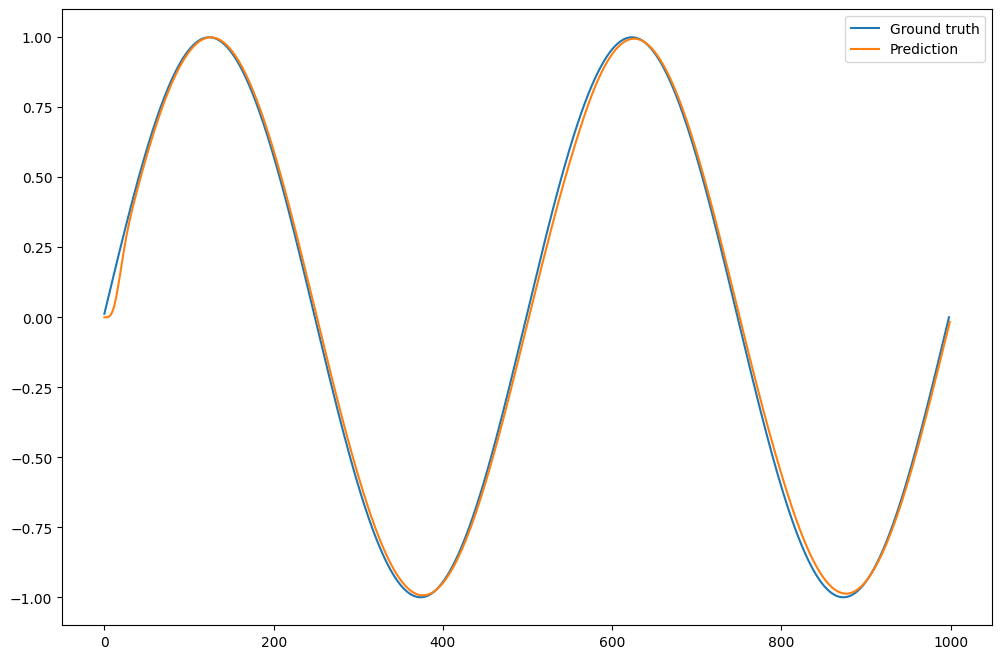

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(X[1:], label="Ground truth")
plt.plot(readouts, label="Prediction")
plt.legend()
plt.show()

In [9]:
for x in X:
    net.step()
    readouts.append(net.z[0])

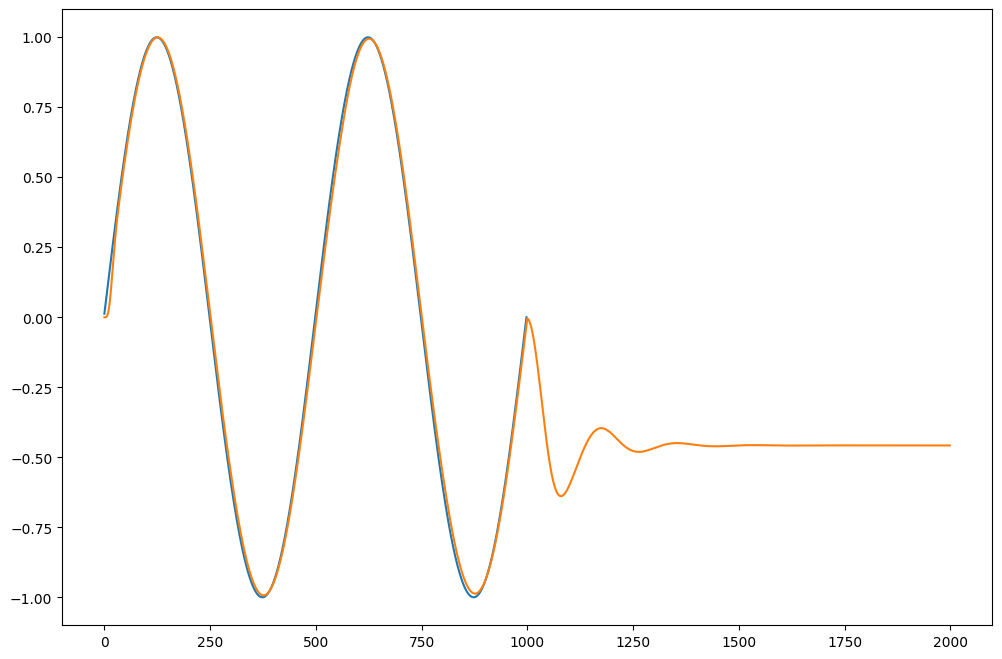

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(X[1:])
plt.plot(readouts)
plt.show()

## FORCE learning with RMS

In [11]:
class ESN_FORCE:
    """
    Echo-state network with feedback and the delta learning rule (LMS).
    """
    def __init__(self, N:int, g:float, delta:float):
        """
        Args:
            N : number of neurons in the reservoir.
            g: spectral radius of the reservoir.
            delta: learning rate.
        """
        self.N = N
        self.g = g
        self.delta = delta

        # Input population
        self.inp = ann.Population(1, ann.Neuron(parameters="r=0.0"))

        # Recurrent population
        self.pop = ann.Population(N, ESN_Neuron)
        self.pop.g = g
        self.pop.bias = np.random.uniform(-1., 1., self.N)

        # Feedback weights
        self.Wi = ann.Projection(self.inp, self.pop, 'in')
        self.Wi.connect_all_to_all(weights=ann.Normal(0.0, 1.0))

        # Recurrent weights
        self.Wrec = ann.Projection(self.pop, self.pop, 'exc')
        self.Wrec.connect_all_to_all(weights=ann.Normal(0., 1/np.sqrt(N)))

        # Output weights
        self.Wout = np.zeros((1, self.N))
        self.z = np.zeros(1)

        # Inverse correlation matrix of inputs for learning readout weights
        self.P = np.identity(self.N)/self.delta

        # Monitor
        self.monitor = ann.Monitor(self.pop, 'r')

        ann.compile()

    def step(self):
        "Performs one step of the simulation."

        # Set the previous readout output as the new input
        self.inp.r = self.z

        # Update the reservoir
        ann.step()

        # Compute the readout
        self.z = self.Wout @ self.pop.r

    def train(self, target:float):
        """
        Trains the readout weights with the delta learning rule.

        Args:
            target: desired output.
        """

        # Multiply the rates with the inverse correlation matrix: P * r
        gain = self.P @ self.pop.r
        
        # Normalization term: 1 + r' * P * r
        normalization_term = (1. + self.pop.r.T @  gain)
        
        # Update the inverse correlation matrix: P <- P - ((P * r)*(P * r)')/(1 + r' * P * r)
        self.P -= np.outer(gain, gain) / normalization_term
        
        # Learning rule: W <- W + e * (P * r)/(1 + r' * P * r)
        self.Wout += (target - self.z) * gain / normalization_term


In [12]:
duration = 1000 # 1000 steps = one second
t = np.linspace(0, 1, duration) # time axis
X = np.sin(2*np.pi*t*2.)

In [13]:
ann.clear()
net = ESN_FORCE(N=200, g=1.0, delta=1.0)

readouts= []
# Training
for x in X:
    net.step()
    net.train(x)
    readouts.append(net.z[0])

# Autoregression
for x in X:
    net.step()
    readouts.append(net.z[0])

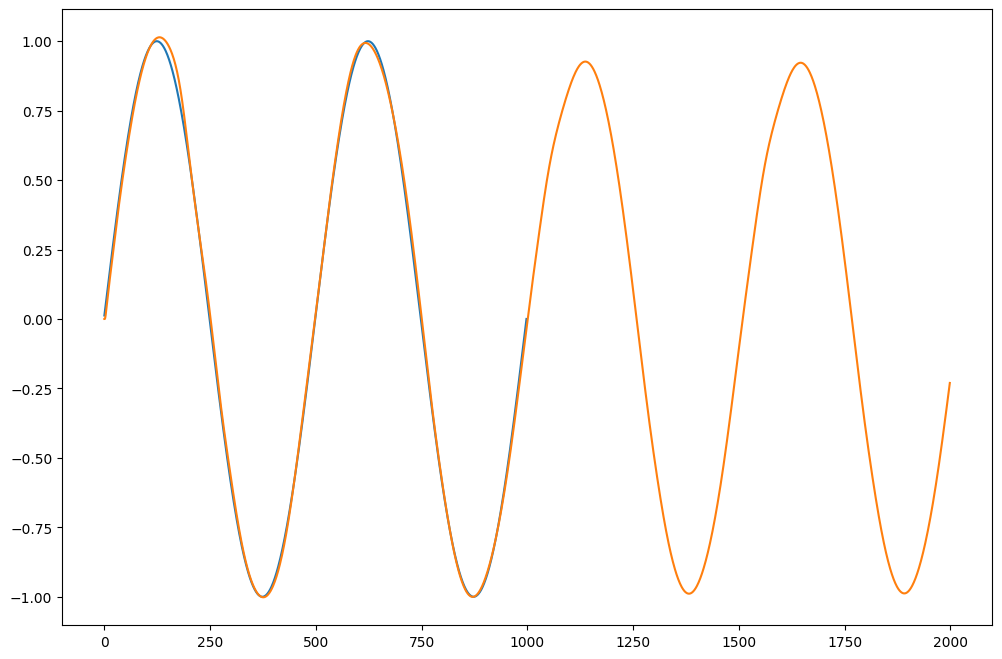

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(X[1:])
plt.plot(readouts)
plt.show()